<a href="https://colab.research.google.com/github/01star01ek/01star01ek/blob/main/swimswap%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%A7%84%EC%A7%9C%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil

# 설치
print("🔧 설치 중...")
if os.path.exists('/content/SimSwap'): shutil.rmtree('/content/SimSwap')
%cd /content
!git clone -q https://github.com/woctezuma/SimSwap.git SimSwap
%cd SimSwap
!git checkout -q upgrade-insightface

# NumPy 버전 고정하여 설치
!pip install --force-reinstall "numpy<2.0"
!pip install -q torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install -q insightface==0.7.3 onnxruntime moviepy opencv-python imageio==2.34.0

🔧 설치 중...
/content
/content/SimSwap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 388.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.0.1+cu118 which is incompatible.
     ━━━━━━━━━━

In [2]:
# 모델 다운로드
print("📥 모델 다운로드...")
!mkdir -p arcface_model parsing_model/checkpoint checkpoints insightface_func/models
!wget -q https://github.com/woctezuma/SimSwap-colab/releases/download/1.0/arcface_checkpoint.tar -O arcface_model/arcface_checkpoint.tar
!wget -q https://github.com/neuralchen/SimSwap/releases/download/1.0/checkpoints.zip -O checkpoints.zip
!wget -q https://github.com/neuralchen/SimSwap/releases/download/1.0/79999_iter.pth -O parsing_model/checkpoint/79999_iter.pth
!wget -q https://github.com/woctezuma/SimSwap-colab/releases/download/antelope/antelope.zip -O antelope.zip
!wget -q https://github.com/neuralchen/SimSwap/releases/download/512_beta/512.zip -O 512.zip
!unzip -q checkpoints.zip -d checkpoints && unzip -q 512.zip -d checkpoints && unzip -q antelope.zip -d insightface_func/models/

📥 모델 다운로드...


In [3]:
# PyTorch 2.6 호환성 수정
print("🔧 PyTorch 호환성 수정...")
!cp models/fs_model.py models/fs_model.py.backup
!sed -i 's/torch.load(netArc_checkpoint, map_location=torch.device("cpu"))/torch.load(netArc_checkpoint, map_location=torch.device("cpu"), weights_only=False)/g' models/fs_model.py

# det_size 초기 설정
!sed -i 's/det_size=(640,640)/det_size=(320,320)/g' test_wholeimage_swapsingle.py

🔧 PyTorch 호환성 수정...


In [1]:
from google.colab import files
import cv2, matplotlib.pyplot as plt

print("📁 소스 이미지 (바꿀 얼굴) 업로드:")
source_uploaded = files.upload()
!cp {list(source_uploaded.keys())[0]} source.jpg

print("📁 타겟 이미지 (원본) 업로드:")
target_uploaded = files.upload()
!cp {list(target_uploaded.keys())[0]} target.jpg

📁 소스 이미지 (바꿀 얼굴) 업로드:


Saving source.png to source.png
📁 타겟 이미지 (원본) 업로드:


Saving target.png to target.png


In [4]:
%cd /content/SimSwap/

/content/SimSwap


In [5]:
# test_wholeimage_swapsingle.py의 탐지 설정 수정
with open('test_wholeimage_swapsingle.py', 'r') as f:
    content = f.read()

# 임계값 설정 추가
lines = content.split('\n')
new_lines = []
for line in lines:
    new_lines.append(line)
    if 'app.prepare(' in line:
        new_lines.append('    # 탐지 임계값 조정')
        new_lines.append('    if hasattr(app.models, "detection"):')
        new_lines.append('        app.models["detection"].nms_thresh = 0.3')
        new_lines.append('        app.models["detection"].det_thresh = 0.3')

with open('test_wholeimage_swapsingle.py', 'w') as f:
    f.write('\n'.join(new_lines))

print("✅ 스크립트 설정 수정 완료")

✅ 스크립트 설정 수정 완료


In [11]:
!python test_wholeimage_swapsingle.py \
    --crop_size 224 \
    --use_mask \
    --no_simswaplogo \
    --name people \
    --Arc_path arcface_model/arcface_checkpoint.tar \
    --pic_a_path source.jpg \
    --pic_b_path target.jpg \
    --pic_specific_path target.jpg \
    --output_path ./output/

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
------------ Options -------------
Arc_path: arcface_model/arcface_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 224
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsa

생성된 파일: ['result_whole_swapsingle.jpg', 'result.jpg']


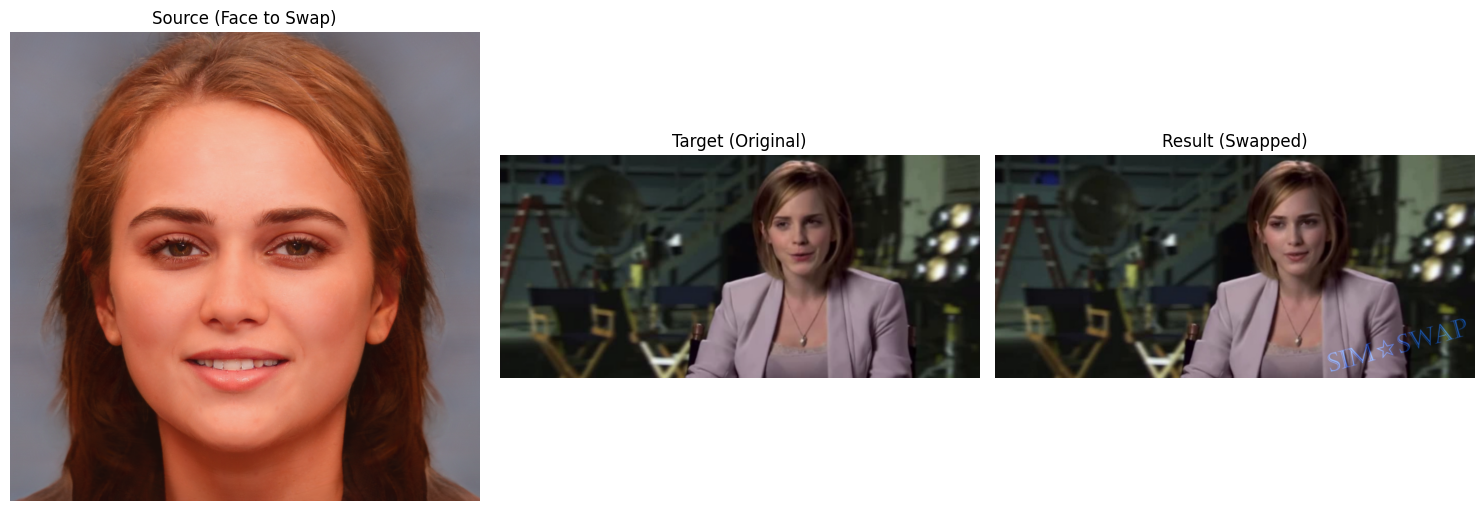

In [10]:
import os
import matplotlib.pyplot as plt

# 결과 파일 확인
output_files = [f for f in os.listdir('./output/') if f.endswith(('.jpg', '.png'))]
print(f"생성된 파일: {output_files}")

if output_files:
    # 결과 이미지 표시
    result_img = cv2.imread(f'./output/{output_files[0]}')
    result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread('source.jpg'), cv2.COLOR_BGR2RGB))
    plt.title('Source (Face to Swap)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(cv2.imread('target.jpg'), cv2.COLOR_BGR2RGB))
    plt.title('Target (Original)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_rgb)
    plt.title('Result (Swapped)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ 결과 파일이 생성되지 않았습니다.")